# Single Dataset Training Gigtforeningen

This notebook exhibits us training the SimFL model on just one dataset. The intention of this is to provide a benchmark for us to better understand our federated learning results. We follow through the following phases:

- establishing our environment
- preprocessing the data
- training our model
- evaluating our model
- providing predictions on test data

## Establishing our Remote Execution Environment

First we log in to the SAIL backend. This allows us to query for our contract of interest to see if any remote execution VMs have been initialised for it. We push our safe functions to the remote execution VM and then query for details of the table it holds. 

In [1]:
#First we pull in our tools
from sail.core import VMSetup, registersafeobj,login,connect,pushsafeobj,querydata,get_fns
from sail.data import RemoteDataFrame, Utils, RemoteSeries
from sail.algo import fdxgb

from sail.tmp import shap_private, get_tmp_fns

In [2]:
import time

In [3]:
#We load our safe object storage location
import json, requests
soPath = "/Engineering/Milestone3/EndPointTools/SafeObjectEditor/KPMG/safeobjects"
backendIP = "20.185.6.111"

registersafeobj(soPath)
print("[P]safe objects registered")

[P]safe objects registered


In [4]:
#We log in to the backend using our credentials, receive eosb token
from sail.core import login
eosb = login("adam.hall@secureailabs.com", "-OJBFE2qw-OJBFE2qw", 6200, backendIP)
print("[P]login success")
print(eosb)

[P]login success
5iEQAhtloSNZp4nbyKcSNCAPdQdNtGkYLicOrZ6g02P5iD1r0EP+iwytSOCD3PNZdoaL1SYDAAB09HTxtvEsuYEoDvTjdhdf2CuCIL6yoyKjYjt1Ue1Gxbn2WsXfhQp7y/fogC40KIrIIzHpv9Os8awqXhggN5FWAmTkARKfQsOD/Gn+ok+4ibqEV03TAEp+fRyaA91DcuSCSEf6FWaTQRBLH/3S3jR7vOY43kbTrNzd1Z0MIK3akq0UOTsjpau2aj+45e0hW+K55tCZfpEkiRUacAM/GXw3zSsV8AAAMYJra4MludSXcRl3uiBV9tD64jVcCO7ShscTLj5rOLbSaVUrlWciB5CQT88tZCAX3S1MqddEbt2shtGR2UnUapKfTN9XrwdwCADbaF5se+kZrIjmJgtVbVBa1AfXUnwz96PwMufXHzTI8+T6vdPJStEkCwskTGKdLgdwV7/g9XfkePNoH4HqMRwVBL8u13JdEWPJdYbyFXLQIpIix7CxbqYemuD6kCloNI8w5Eiy06GRDmmZxg+mm+vh+JH9qcFmhG7epFrgkC4ufMDUv8CNWRRRG9uZECXIGInje3WY01kLfWcq8dF7Q/VCpBvLNeBMJzdC5WoP2q0MXQeXCvYMLPP6VHagCX1VQCSsd3pYfLjsJYFwe96bEGpnZ4yBOBuAkzf167FBijq6RTAGPpUe51uHYFkQyoEozUZ43is64wZ1OGXZRZkY66B/Sv0TzJ3cAiuzEuAUByWuyecilA6/iAVsfQLRHoLmEr+xNxVnyjVZWa1XDYIyIWzCR55h2BvoZ4xlzpNyPY30dy4gLR6guoyNtm3bBPe0G44gYjVgAmzN2SeVSJClAyJOjhmTzyDv6/QOxs6HdB6aFoJVvo/HAwI4OvfRdVEknW4lxuYJ9vgMbkkLTioeo+5UNusRnxGWVfYbZvNh77wMRxfLgr9Nq1ToN0E+5CGXOmZjgSgwAntVR/D

In [5]:
#specify our digital contract, set our backend ip, query for backend for VMs associated to contract.
dc =  [{"DigitalContractGuid":"{3BFF6633-477E-43D8-B3A3-F3079A1AF10F}"}]
backendIP = "20.185.6.111"
url = "https://"+backendIP+":6200/SAIL/VirtualMachineManager/GetRunningVMsIpAdresses?Eosb="+eosb

In [6]:
#obtain virtual machines ids and dataset ids, so we can confirm the datasets are intact and ready for studying
import json, requests
payloads = []
for item in dc:
    temp = json.dumps(item)
    payloads.append(temp)

headers = {
    'Content-Type': 'application/json'
}

ips = []
for payload in payloads:
    print(payload)
    response = requests.request("GET", url, headers=headers, data=payload, verify=False)
    print(response)
    response = response.json()
    print(response)
    for key in response['VirtualMachines']:
        ips.append(response['VirtualMachines'][key])
        print(ips)

{"DigitalContractGuid": "{3BFF6633-477E-43D8-B3A3-F3079A1AF10F}"}


/usr/local/lib/python3.8/dist-packages/urllib3/connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host '20.185.6.111'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


<Response [200]>
{'Status': 200.0, 'VirtualMachines': {'F5F6D2727E9040DDAC61F042B07AD0ED': '20.107.25.57'}}
['20.107.25.57']


In [7]:
#Connect to each IP address in the list of IP addresses returned by the backend
from sail.core import connect

vmids = []
for ip in ips:
    vmid = connect(ip, 3500)
    vmids.append(vmid)
    print("[P]virtual machine connection to ip: {0} success".format(ip))
vmids

[P]virtual machine connection to ip: 20.107.25.57 success


['{78063BA7-6BB9-48D2-A850-9297A8E79417}']

In [8]:
#Push our safe objects to the remote VM
from sail.core import get_fns, pushsafeobj

fns = get_fns()
for vm in vmids:
    for key in fns:
        pushsafeobj(vm, fns[key])
print("[P]safe object pushed to virtual machines")
fns

[P]safe object pushed to virtual machines


{'getitem': 'F11C49327A9244A5AEE568B531C6A957',
 'getattr': '9C4019584DB04B1A9BF05EC91836BCB0',
 'setitem': 'A04E4CC9E3BC4A7B9AFAB6CB3E040FAC',
 'iter': 'CC8B5A66C10F47A1A977E2BE2B522768',
 'next': '6D48AC3C3245411992E65E5FF5B90DDB',
 'rdf_describe': '18F2566E7FF34D77A7DE668DD220CEFD',
 'rdf_drop': '9A04D50B403C4716A79CABEF1F90D832',
 'rdf_dropna': '039181877F8A492A86A4BD996D0AD4E2',
 'rdf_merge': '8C938D7D313A49C09509D6A43AAFD096',
 'rdf_groupby': '3E3716FCA7DE4ABEB8A3FAB4DA14EA9D',
 'rdf_query': 'BF18C294BCCC4B9C94624C79D2506CCC',
 'rdf_sort_values': '10DCB6636C8A4832AD6CE7BCDB1F9983',
 'rdf_set_index': '09EE6479EE97461DBC4E44D95D77235B',
 'rdf_reset_index': 'F408E02C932D47C49BC5DC640C108AEB',
 'rdf_label_encode': '56D864CD0B81459CB0540E364BB49D6F',
 'groupby_agg': 'CEFAABE1879741269037050B25A5CCFD',
 'groupby_diff': '9604982079924320B6C7B6DCA27CFC6C',
 'groupby_cumsum': 'AB04C77FA5DD4B1B8AAD2867F44BC886',
 'groupby_first': 'FF2156013B9A483F9FC8F0DB27E3B74D',
 'series_add': 'B13E83BD

In [9]:
#Query for tables on the remote host and report back table names
from sail.core import querydata

table = []
for vm in vmids:
    tableid = querydata(vm)
    table.append(tableid)
print("[P]obtain table ids")

datasets = table
table

[P]obtain table ids


[{'agreement09nov': '804DD44A900818499D3FA68CDDF1C844',
  'agreementMapping': '68DA5CD6CE4D3D4F9E5A33E587B80958',
  'contact09nov': '613438CFD17362418C67F98AD9B015B2',
  'createReasonMapping': '431F1BD48F684140ADE8FB1BB5A80568',
  'payment09nov': '9C47F4F3BBE07B4F89256B1EED3C960D'}]

For each of the tables we have, we'd like to read these into a pandas dataframe on the remote execution VM. This dataframe his held remotely and is referenced by the data_id of the dataframe held remotely.

In [10]:
start_time = time.time()


data = []
i = 0
for vm in vmids:
    util = Utils(vm, fns)
    data.append([util.read_csv(table[i]['agreement09nov']), util.read_csv(table[i]['contact09nov']), util.read_csv(table[i]['payment09nov']), util.read_csv(table[i]['agreementMapping']), util.read_csv(table[i]['createReasonMapping'])])
    i+=1
    print(i)

print(time.time() - start_time)

1
28.033180236816406


We can pass a specfic data_id to the RemoteDataFrame object to expose a traditional pandas style api to the dataframe held remotely. This allows us to query columns, index values etc. of the dataframe held remotely.

In [11]:
df = RemoteDataFrame(vmids[0], data[0][0], fns)
df.columns

Index(['AgreementGUID', 'AgreementID', 'Startdate', 'CreateReason',
       'Cancelreason', 'CancelDate', 'ChannelName', 'ChannelD',
       'AgreementType', 'FutureCancelDate', 'FutureCancel', 'ContactGUID',
       'ContactID'],
      dtype='object')


## Preprocessing

Next, we'd like to preprocess the tables associated with our contract into training data. We do this using a preprocessing safe function which follows the KPMG pre-processing with some minor edits. We instantiate our model first because our we store this preprocessing function in the fdxgb class as a matter of convenience. We're going to set up the fdxgb model at the most basic setting to begin with, just passing in our array of vmids associated with the contracts we specified in the beginning. 

In [12]:
#Initialise our fdxgb class
model = fdxgb(vmids)

In [13]:
start_time = time.time()

#Preprocess to raw data and obtain the final dataframe 
processed_data = model.data_preprocessv6(data)

print(time.time() - start_time)

296.31864833831787


In [14]:
#Here we can see the data_ids of the results of out preprocessing safe function
processed_data

[['{E2FE4E23-AD02-4B79-BD4F-22BB4E96ED7F}.22781F1189EE4A59811FC87A58F87FE1',
  '{E2FE4E23-AD02-4B79-BD4F-22BB4E96ED7F}.A25D92AC2CE3419183BA2D2DC327853E',
  '{E2FE4E23-AD02-4B79-BD4F-22BB4E96ED7F}.1D45849AE8E348AC9E0E1D327963720B',
  '{E2FE4E23-AD02-4B79-BD4F-22BB4E96ED7F}.DFF3006247B84C48B8F6566A1FBCF450',
  '{E2FE4E23-AD02-4B79-BD4F-22BB4E96ED7F}.04791A2940C246C9BFF33BD8CEAC5A4E',
  '{E2FE4E23-AD02-4B79-BD4F-22BB4E96ED7F}.E0C8C95A43FE48A980DD74EB94B50D52',
  '{E2FE4E23-AD02-4B79-BD4F-22BB4E96ED7F}.0BF4AC222C15496884B65150893F2BBA',
  '{E2FE4E23-AD02-4B79-BD4F-22BB4E96ED7F}.E87E761B37B14F8CA829CC9558A3B22E',
  '{E2FE4E23-AD02-4B79-BD4F-22BB4E96ED7F}.A532E0888F9943A3AE5CDD8EEA16A5C8',
  '{E2FE4E23-AD02-4B79-BD4F-22BB4E96ED7F}.178301F3D4C54CFF838BB97729BD0D96']]

In [15]:
#Next we sort these results into their respective datasets
#[y_val, y_test, X_val, X_test, X_train, y_train, X_train_val, y_train_val]
X_train = [processed_data[0][0]]
y_train = [processed_data[0][1]]
X_val = [processed_data[0][2]]
y_val = [processed_data[0][3]]
X_train_val = [processed_data[0][4]]
y_train_val = [processed_data[0][5]]
X_test = [processed_data[0][6]]
y_test = [processed_data[0][7]]

## Training our Model

First we set the parameters of our federated xgboost model. Then we call the model.fit() function to train a new classifier on the training data retrieved in the pre-processing phase. 

In [16]:
#We pass the data_id for one of our X sets to a remote dataframe so we can report the columns.
#We do this because we need the value in order to set the number of features for the model and to label
#our output shap feature columns later on.
X_train_df = RemoteDataFrame(vmids[0], X_train[0], fns)
cols = X_train_df.columns
cols

Index(['Age_max', 'ChargedAmount_sum', 'PostalCode_max', 'PaidAmount_sum',
       'AgreementGUID_count', 'PaymentGUID_count', 'Donation_sum',
       'Medlemskab_sum', 'Product_sum', 'Lottery_sum',
       'payment_on_agreement_sum', 'months_since_start_min',
       'months_since_start_max', 'months_since_last_payment_min',
       'months_since_last_payment_max', 'months_since_missing_payment_min',
       'months_since_missing_payment_max', 'missing_payment_sum',
       'AgreementType_donation_sum', 'AgreementType_householdMembership_sum',
       'AgreementType_householdMembershipWithDonation_sum',
       'AgreementType_lottery_sum', 'AgreementType_membershipWithDonation_sum',
       'AgreementType_personalMembership_sum', 'AgreementType_event_sum',
       'AgreementType_researchRelated_sum', 'ChannelD_Bank_sum',
       'ChannelD_Betalingsservice_sum', 'ChannelD_Card_sum',
       'ChannelD_Giro_sum', 'ChannelD_MobilepaySubscription_sum',
       'ChannelD_Mobilepay_sum', 'ChannelD_Invoice

In [17]:
#We check the value counts of the training data so we can appropriately set the scale position weight 
# parameter of our model to deal with calss imbalance. This is the ratio of positive to negative classes.
y_train_df = RemoteDataFrame(vmids[0], y_train[0], fns)
lab = y_train_df.value_counts()
lab

0    679099
1      8669
Name: is_churned_within3m, dtype: int64

In [18]:
int(lab[0]/lab[1])

78

In [19]:
#Setup parameters for federated xgboost model
from sail.algo import fdxgb
model_params = {
# "colsample_bylevel": ,
# "colsample_bytree": ,
# "gamma": ,
"learning_rate": 0.1285296847082715,
# "max_delta_step": ,
"max_depth": 9,
"n_estimators": 150,
# "reg_alpha": ,
# "reg_lambda": ,
"subsample": 0.8,
"scale_pos_weight": int(lab[0]/lab[1])
}

model.params = model_params

In [20]:
#Set the feature dimensions as described above
model.feature_num = len(cols)

In [21]:
#Train a new model on the training data

start_time = time.time()

xgbmodel = model.fit(X_train,y_train)

print(time.time() - start_time)

all_hashes has len 71
[20:56:14] WARNING: ../src/learner.cc:576: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Tree 1
Tree 2
Tree 3
Tree 4
Tree 5
Tree 6
Tree 7
Tree 8
Tree 9
Tree 10
Tree 11
Tree 12
Tree 13
Tree 14
Tree 15
Tree 16
Tree 17
Tree 18
Tree 19
Tree 20
Tree 21
Tree 22
Tree 23
Tree 24
Tree 25
Tree 26
Tree 27
Tree 28
Tree 29
Tree 30
Tree 31
Tree 32
Tree 33
Tree 34
Tree 35
Tree 36
Tree 37
Tree 38
Tree 39
Tree 40
Tree 41
Tree 42
Tree 43
Tree 44
Tree 45
Tree 46
Tree 47
Tree 48
Tree 49
Tree 50
Tree 51
Tree 52
Tree 53
Tree 54
Tree 55
Tree 56
Tree 57
Tree 58
Tree 59
Tree 60
Tree 61
Tree 62
Tree 63
Tree 64
Tree 65
Tree 66
Tree 67
Tree 68
Tree 69
Tree 70
Tree 71
Tree 72
Tree 73
Tree 74
Tree 75
Tree 76
Tree 77
Tree 78


## Model Validation

Having trained our model, we will now evaluate the performance against the validation set. We do this by generating confusion matrices for the model over 100 threshold points, calculating the average precision/ recall and plotting this curve over these given threshold points.

In [22]:
#calculate our precision recall over 100 threshold points.

start_time = time.time()

results =  model.aucpr_score(xgbmodel, X_val, y_val)

print(time.time() - start_time)

15.233111381530762


In [23]:
#For each dataset in our X_val set, tally the confusion matrices and calculate the precision
precision = []
recall = []
for i in range(len(results[0][3])):
    tmp = [0,0,0,0]
    print("Threshold "+str(i))
    print(results[0][3][i])

    #The confusion matrix is inverted, that's why this is inverted. The negative class is the true class
    tmp[0]+=results[0][3][i].ravel()[0]
    tmp[1]+=results[0][3][i].ravel()[1]
    tmp[2]+=results[0][3][i].ravel()[2]
    tmp[3]+=results[0][3][i].ravel()[3]
    
    if (tmp[3]+tmp[1]) == 0:
        prec = 0
    else:
        prec = tmp[3]/(tmp[3]+tmp[1])
    reca = tmp[3]/(tmp[3]+tmp[2])
    precision.append(prec)
    recall.append(reca)

Threshold 0
[[    0 61383]
 [    0   745]]
Threshold 1
[[58943  2440]
 [  696    49]]
Threshold 2
[[60755   628]
 [  725    20]]
Threshold 3
[[61088   295]
 [  735    10]]
Threshold 4
[[61231   152]
 [  736     9]]
Threshold 5
[[61280   103]
 [  738     7]]
Threshold 6
[[61311    72]
 [  740     5]]
Threshold 7
[[61324    59]
 [  741     4]]
Threshold 8
[[61330    53]
 [  741     4]]
Threshold 9
[[61334    49]
 [  741     4]]
Threshold 10
[[61338    45]
 [  741     4]]
Threshold 11
[[61339    44]
 [  742     3]]
Threshold 12
[[61341    42]
 [  742     3]]
Threshold 13
[[61341    42]
 [  742     3]]
Threshold 14
[[61341    42]
 [  742     3]]
Threshold 15
[[61342    41]
 [  742     3]]
Threshold 16
[[61342    41]
 [  742     3]]
Threshold 17
[[61343    40]
 [  742     3]]
Threshold 18
[[61347    36]
 [  742     3]]
Threshold 19
[[61348    35]
 [  742     3]]
Threshold 20
[[61348    35]
 [  742     3]]
Threshold 21
[[61349    34]
 [  742     3]]
Threshold 22
[[61349    34]
 [  742     3]

In [24]:
#Average Precision
sum(precision)/len(precision)

0.3866724355062741

In [25]:
#Average Recall
sum(recall)/len(recall)

0.013275167785234864

[0.011991372650012877, 0.019686621132985135, 0.030864197530864196, 0.03278688524590164, 0.055900621118012424, 0.06363636363636363, 0.06493506493506493, 0.06349206349206349, 0.07017543859649122, 0.07547169811320754, 0.08163265306122448, 0.06382978723404255, 0.06666666666666667, 0.06666666666666667, 0.06666666666666667, 0.06818181818181818, 0.06818181818181818, 0.06976744186046512, 0.07692307692307693, 0.07894736842105263, 0.07894736842105263, 0.08108108108108109, 0.08108108108108109, 0.08108108108108109, 0.08108108108108109, 0.08108108108108109, 0.08108108108108109, 0.08108108108108109, 0.08108108108108109, 0.08108108108108109, 0.08108108108108109, 0.08108108108108109, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.5, 0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 

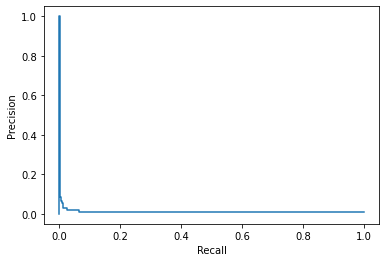

In [26]:
#Plot the decision recall graph using the points generated above
import numpy as np
print(precision)
print(recall)
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot()

## Prediction and Prediction Explainability 

In the next section we'll generate some predictions for the GFR test set. With these predictions, we'll also produce shap values to explain the predicitions. First we produce shap plots locally to the remote machine and pull back the created image. This plot includes the data values in the heatmap. This is to be used for diagnosing performance of the model.

The second shap function performs shap analysis remotely using the test set and pulls back the shap values, base_values and model expected value to be used on the orchestrator side. We use this to produce the prediction output with shap values csv deliverable.

### SHAP Plot for model diagnosis

919.6669688224792


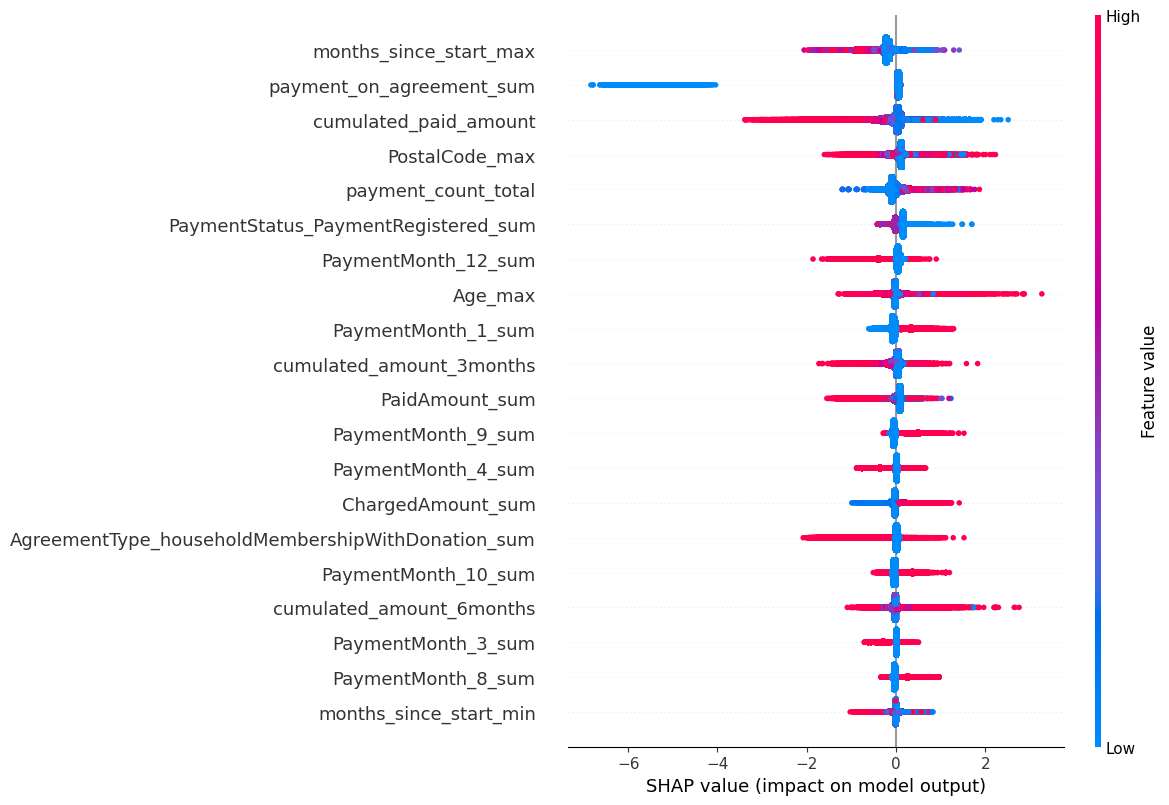

In [27]:
#Generate shap images on the local machine, pull back the plots that were generated
start_time = time.time()

model.model = xgbmodel
model.shap(X_test)

print(time.time() - start_time)

### CSV Predictions with SHAP Values Deliverable

In [28]:
#Pull in our final set of safe functions
from sail.tmp import shap_private, get_tmp_fns

tmp_fns = get_tmp_fns()

In [29]:
#Push these safe functions to the remote VM
for vm in vmids:
        for key in tmp_fns:
            pushsafeobj(vm, tmp_fns[key])

In [30]:
#Generate shap explanation values for the produced model and the test data
explanation_values, explanation_base_values, expected_value = shap_private(vmids[0], xgbmodel, X_test[0], tmp_fns)

['{EB7C1B40-7AB6-4BAB-854D-D8DFDD147EEF}']


In [31]:
#Turn the labels for the test set into a RemoteSeries to get access to the Pandas Series API
y_test_df = RemoteDataFrame(vmids[0], y_test[0], fns)
lab = y_test_df.value_counts()
lab

0    862377
1     11419
Name: is_churned_within3m, dtype: int64

In [32]:
#Grab the index values from the labels so that we can associate
#  the predictions with these same datapoints
temp_index = y_test_df.index

In [33]:
#Generate csv deliverable
import pandas as pd

customer_guid = []
date = []
for i in range(0, len(temp_index)):
    customer_guid.append(temp_index[i][0])
    date.append(temp_index[i][1])

# Add references to customer instances
df1 = pd.DataFrame()
df1['CustomerGUID'] = customer_guid
df1['Date'] = date

#add predictions
preds = model.predict(X_test)
df1['Predictions Probabilities'] = 1/(1+ np.exp(-preds[0]))
df1['Predictions Log Odds'] = preds[0]
df1['SHAP Base Values'] = explanation_base_values

#Add Explanation Values
df2 = pd.DataFrame()
df2 = pd.DataFrame(explanation_values)
df2.columns = cols
results_for_csv = pd.concat([df1, df2], axis=1, join='inner')
results_for_csv.to_csv('./predictions_shap_GFR_test.csv')
results_for_csv.head()

,CustomerGUID,Date,Predictions Probabilities,Predictions Log Odds,SHAP Base Values,Age_max,ChargedAmount_sum,PostalCode_max,PaidAmount_sum,AgreementGUID_count,...,PaymentMonth_9_sum,PaymentMonth_10_sum,PaymentMonth_11_sum,PaymentMonth_12_sum,cumulated_paid_amount,cumulated_amount_3months,cumulated_amount_6months,payment_count_last3m,payment_count_last6m,payment_count_total
0,000042c4-ee04-e811-8112-5065f38be571,2020-01-01,0.001485,-6.510939,-4.428437,-0.096094,0.107753,-0.108530,-0.058272,0.006275,...,-0.049115,-0.004520,-0.006695,0.078789,0.061503,0.038759,-0.001825,0.001477,-0.004398,-0.065452
1,000042c4-ee04-e811-8112-5065f38be571,2020-02-01,0.007279,-4.915498,-4.428437,-0.006957,-0.022399,0.078938,0.081365,-0.005572,...,-0.060979,-0.052193,-0.037136,0.026106,0.068277,0.009440,-0.011892,-0.034081,-0.004254,-0.109767
2,000042c4-ee04-e811-8112-5065f38be571,2020-03-01,0.017797,-4.010777,-4.428437,-0.055829,0.131394,0.104524,-0.105702,0.009363,...,-0.051989,-0.004630,-0.001173,0.118348,0.247980,0.489076,-0.042305,0.091225,0.007079,-0.007374
3,000042c4-ee04-e811-8112-5065f38be571,2020-04-01,0.008566,-4.751320,-4.428437,-0.005483,-0.046197,0.092369,0.144396,-0.018395,...,-0.061500,-0.046988,-0.033891,0.027131,-0.026222,0.056419,-0.011408,0.003132,-0.000056,-0.040494
4,000042c4-ee04-e811-8112-5065f38be571,2020-05-01,0.007158,-4.932291,-4.428437,-0.006676,-0.045764,0.114646,0.079295,-0.007196,...,-0.060081,-0.046723,-0.033748,0.025553,-0.041373,-0.007784,-0.004557,-0.000493,-0.024172,-0.022434


### SHAP plots produced for model analysis

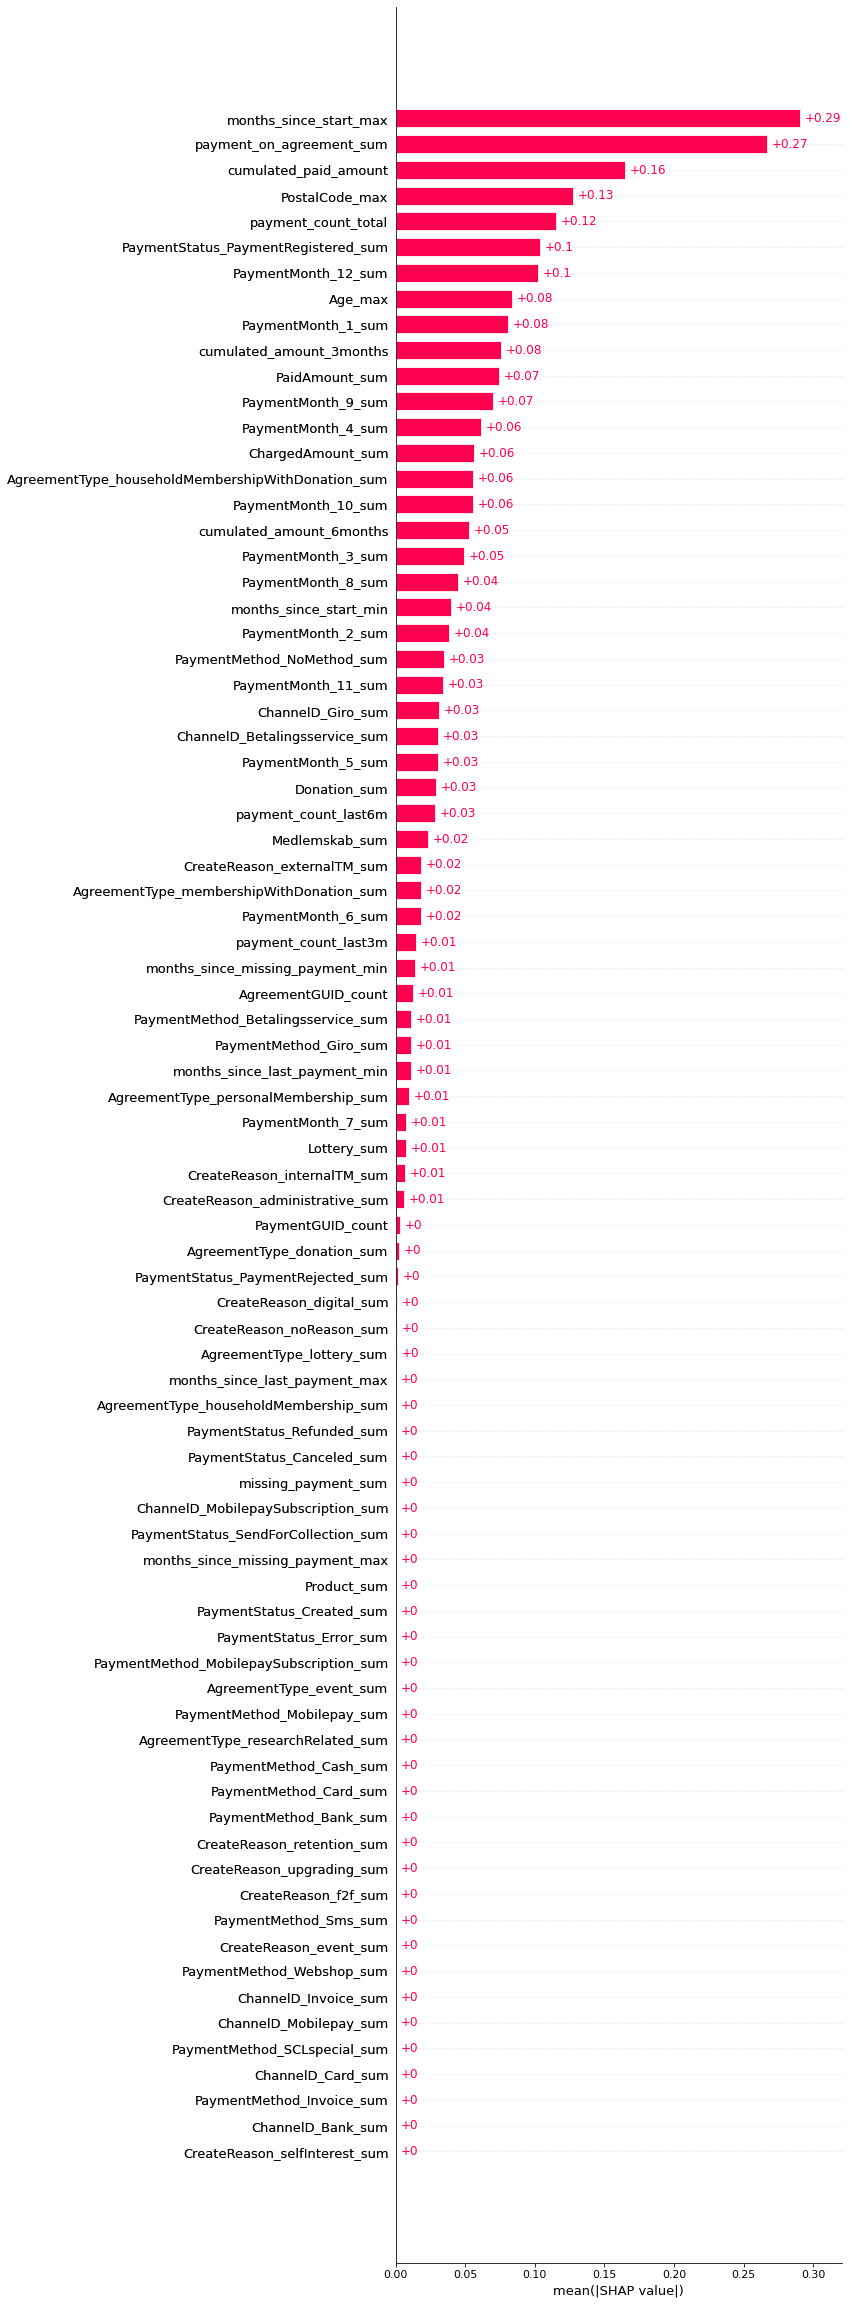

None


elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


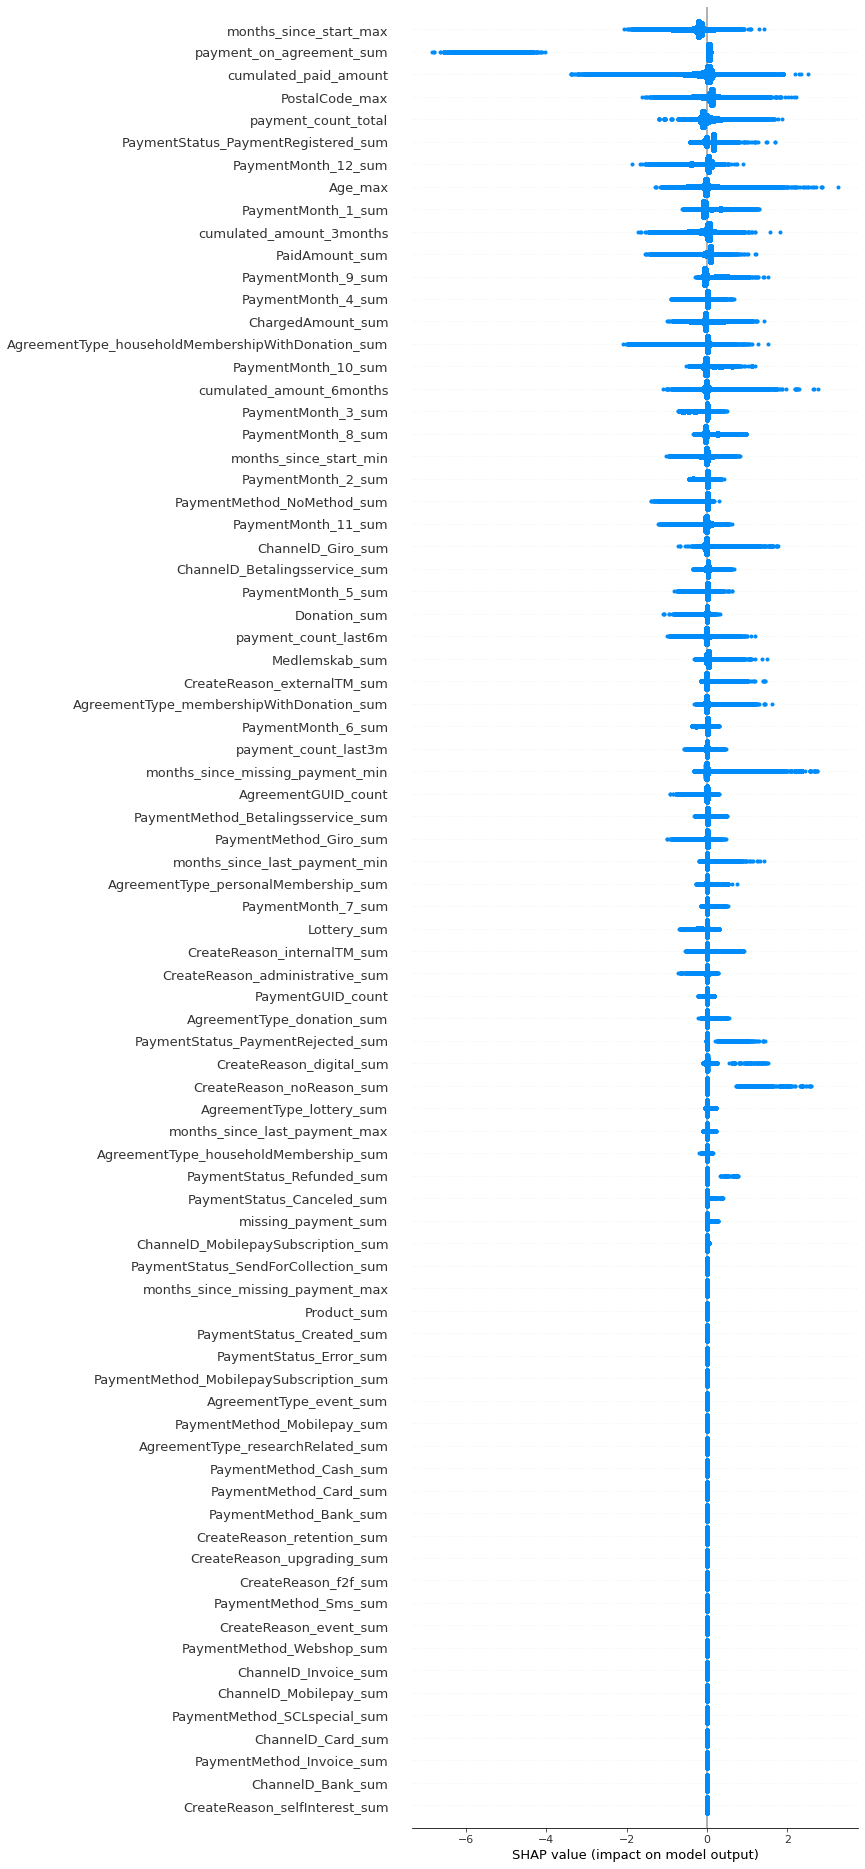

None


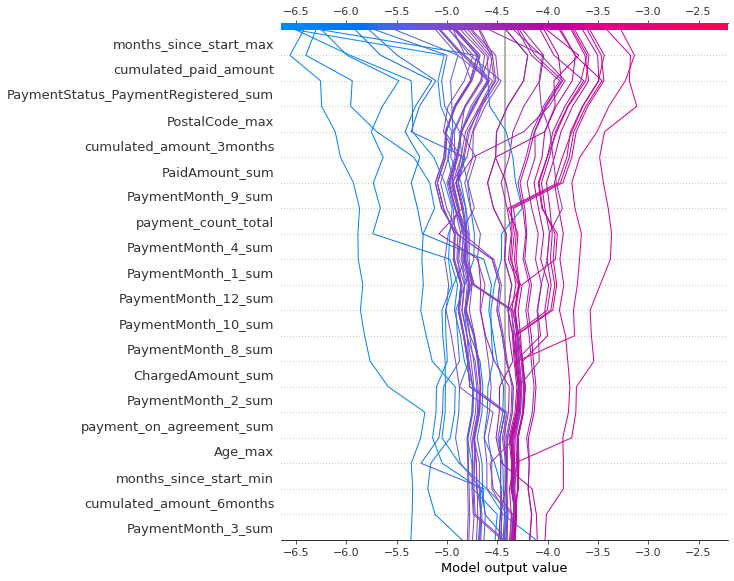

None


In [34]:
#Print shap produced from raw shap values, excluding data

import shap

explanation = shap.Explanation(explanation_values, base_values=explanation_base_values, feature_names=cols)
print(shap.plots.bar(explanation, max_display=len(cols)))
print(shap.plots.beeswarm(explanation, max_display=len(cols)))
print(shap.decision_plot(expected_value, explanation.values[:50], cols))